# Exercise 10 image stitching
Today’s exercise is different from the previous weeks in that it has only a few exercises followed \
by multiple options for how to improve your algorithm. You are going to implement an algorithm \
that can stitch at least two images together, by using RANSAC to estimate a homography.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

### EX 10.1 SIFT Features

Load images and find the features of both.

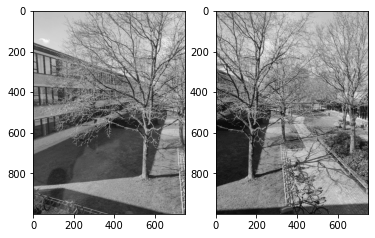

In [3]:
# Load image
left_color = cv2.imread('week10_data/im2.jpg')
left = cv2.cvtColor(left_color, cv2.COLOR_RGB2GRAY)
right_color = cv2.imread('week10_data/im1.jpg')
right = cv2.cvtColor(right_color, cv2.COLOR_RGB2GRAY)
'''
# Need to scale down images for better visualization
scale_percent = 20 # percent of original size
width = int(right.shape[1] * scale_percent / 100)
height = int(right.shape[0] * scale_percent / 100)
dim = (width, height)

# resize image
right = cv2.resize(right, dim, interpolation = cv2.INTER_AREA)
left = cv2.resize(left, dim, interpolation = cv2.INTER_AREA)
'''
# Show
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(left, cmap="gray")
ax[1].imshow(right, cmap="gray");

In [10]:
# 1 SIFT
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(left, None)
kp2, des2 = sift.detectAndCompute(right, None)

# 2 KNN match with two (best and second best)
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# 3 Ratio test!
kp1_indexes = []
kp2_indexes = []
good_matches= []
for m,n in matches:
    if m.distance < 0.70*n.distance:
        good_matches.append([m])
        kp1_indexes.append(m.queryIdx)
        kp2_indexes.append(m.trainIdx)

## 4 extract the keypoints of the "good" matches
kp1 = np.asarray(kp1)
kp2 = np.asarray(kp2)
match_points1 = [p.pt for p in kp1[kp1_indexes]]
match_points2 = [p.pt for p in kp2[kp2_indexes]]

p1 = np.array(match_points1).astype(np.float32)
p2 = np.array(match_points2).astype(np.float32)
p1.shape, p2.shape

((538, 2), (538, 2))

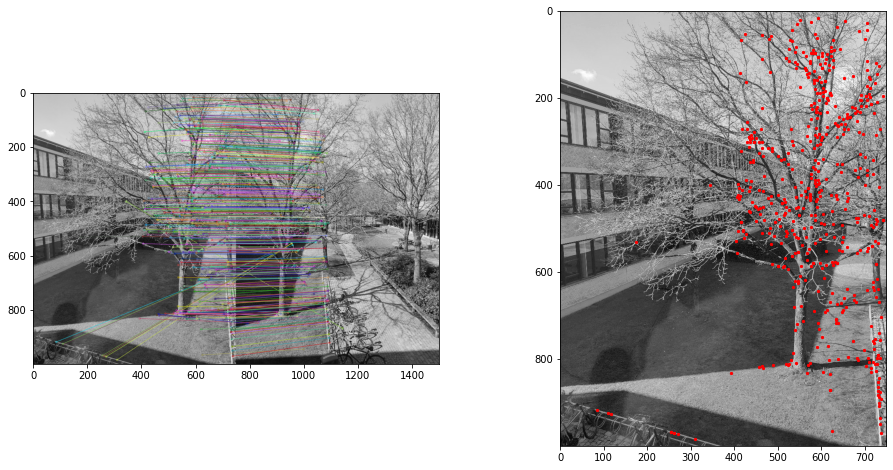

In [15]:
match_image = cv2.drawMatchesKnn(left,kp1,right,kp2,good_matches[:],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
axs[0].imshow(match_image)
axs[1].scatter(p1[:, 0], p1[:, 1], s=5, c="red")
axs[1].imshow(left, cmap="gray");

### 10.2 Implement RANSAC for finding homographies between the images.

What is the minimum number of matches you need to estimate a homography?
- H matrix is 3x3, with 9 DoF. But as H is scale invariant (as its multiplying homogenous points) it only has 8 DoF
- Each pair of points imposes 2 constraints (x,y), meaning that four points gives 8 constraints.
- In conclusion, we need four pairs of points.

Use Equation (2.45) from the lecture notes to compute the distance of a match to a homography. \
Assume σ = 3 and use the formulas from the lecture last week to determine the threshold for when \
a match should be considered an inlier. 

While best practice would be to determine the number of  iterations while running the algorithm,\
you can fix it to i.e. 200. 

To verify that the inliers of the best model are reasonable, visualize them.\
Consider using the following code: 
```plt.imshow(cv2.drawMatches(im1, kp1, im2, kp2, np.array(matches)[bestInliers], None))```\

**NB** On the provided images you should find in the ballpark of a thousand inliers